# satCORPS composite Sketch #2 Subsetting

- Uses starepandas branch granular_democracy


In [1]:
import pystare
import starepandas
import geopandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import datetime

In [2]:
import dask

In [3]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [4]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)
        self.data['BT_12_0um'] = self.source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)
        lat = self.source_nc.groups['map_data']['lat'][:].astype(numpy.double); nlat=len(lat)
        lon = self.source_nc.groups['map_data']['lon'][:].astype(numpy.double); nlon=len(lon)
        self.data['lats'] = numpy.ascontiguousarray(numpy.tile(lat,(nlon,1)).transpose())
        self.data['lons'] = numpy.tile(lon,(nlat,1))

            
starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

In [5]:
# Get some locales
if True:
    states = geopandas.read_file('tl_2019_us_state.zip')
    states = starepandas.STAREDataFrame(states)
    sids = states.make_sids(n_workers=50, resolution=10)
    states.set_sids(sids, inplace=True)
    trixels = states.make_trixels(n_workers=50, wrap_lon=False)
    states.set_trixels(trixels, inplace=True)
    states.split_antimeridian(inplace=True)

In [6]:
if True:
    # roi=states[states.NAME=='Hawaii']
    # roi=states[states.NAME=='California']
    conus = states[~states['NAME'].isin(['Alaska'
                                         ,'Hawaii'
                                         ,'United States Virgin Islands'
                                         ,'Commonwealth of the Northern Mariana Islands'
                                         ,'Guam'
                                         ,'American Samoa'
                                         ,'Puerto Rico'])]
    # roi = conus
    
    conus1 = starepandas.STAREDataFrame(conus.dissolve())
    conus1.set_sids(conus1.make_sids(resolution=7),inplace=True)
    conus1.set_trixels(conus1.make_trixels(),inplace=True)
    
    roi = starepandas.STAREDataFrame(sids=conus1.stare_dissolve(n_workers=50,aggfunc='first'))
    roi.set_trixels(roi.make_trixels(),inplace=True)
    

In [9]:
if False:
    roi.to_hdf('conus-roi.h5','stare_indexed')

In [10]:
starepandas.STAREDataFrame(conus1)

,geometry,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,sids,trixels
0,"MULTIPOLYGON (((-82.94072 24.68283, -82.93289 ...",3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"[3119129770047045639, 3332663724254167043, 307...","MULTIPOLYGON (((-82.52250 24.32624, -82.98181 ..."


In [11]:
# Get some locales
if False:
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world.sort_values(by='name', inplace=True)
    world = starepandas.STAREDataFrame(world)
    
    if False:
        world.plot(trixels=False)

In [12]:
if False:
    roi = world[world.name=='United States of America']
    # roi = world[world.name=='Bahamas']
    # roi = world[world.name=='Vanuatu']
    # roi = world[world.name=='Iceland']

In [13]:
if False:
    roi.set_sids(roi.make_sids(resolution=7),inplace=True)
    roi.set_trixels(roi.make_trixels(),inplace=True)

In [14]:
roi

,sids,trixels
0,3037748317405577223,"POLYGON ((-68.24597 44.62110, -67.86712 43.678..."
1,3037959423638110214,"POLYGON ((-69.04200 46.50281, -68.24597 44.621..."
2,3038100161126465542,"POLYGON ((-67.22055 45.86076, -68.24597 44.621..."
3,3038944586056597511,"POLYGON ((-69.04200 46.50281, -68.52670 47.128..."
4,3038979770428686343,"POLYGON ((-67.99917 47.75118, -68.94132 48.068..."
...,...,...
297,3450073973914599431,"POLYGON ((-108.69725 32.31924, -109.15351 31.3..."
298,3450144342658777095,"POLYGON ((-109.15351 31.30649, -108.34728 30.4..."
299,3450214711402954759,"POLYGON ((-108.69725 32.31924, -109.97485 32.1..."
300,3450249895775043591,"POLYGON ((-111.24716 31.94014, -110.41646 31.1..."


In [15]:
type(roi)

starepandas.staredataframe.STAREDataFrame

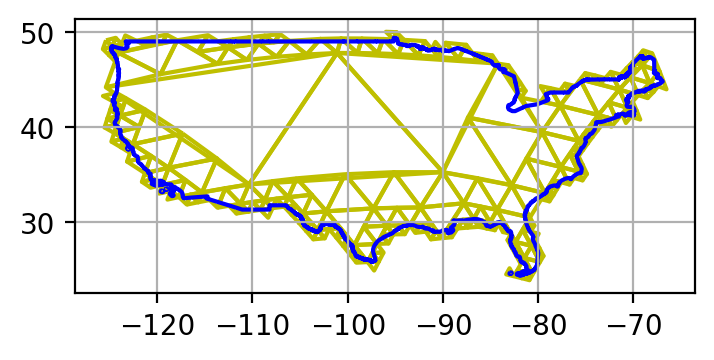

In [16]:
#
if True:
    fig, ax = plt.subplots(figsize=(4,4), dpi=200)
    ax.grid(True)


    roi.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

    del fig,ax

In [17]:
start0 = datetime.datetime.now()

In [18]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name, sidecar=True, latlon=False, sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')

saving:  BT_12_0um
saving:  lats
saving:  lons


In [19]:
# a = composite.stare_intersects(roi['sids'].iloc[0],n_workers=50)
a = composite.stare_intersects(roi['sids'].iloc[:].to_numpy(),n_workers=50)

In [20]:
composite_subset = composite[a]

In [21]:
print(datetime.datetime.now() - start0)

0:00:40.781761


In [22]:
# jdf1=jdf[0:100]
# jdf1=jdf
jdf1=composite_subset

0:00:41.270772


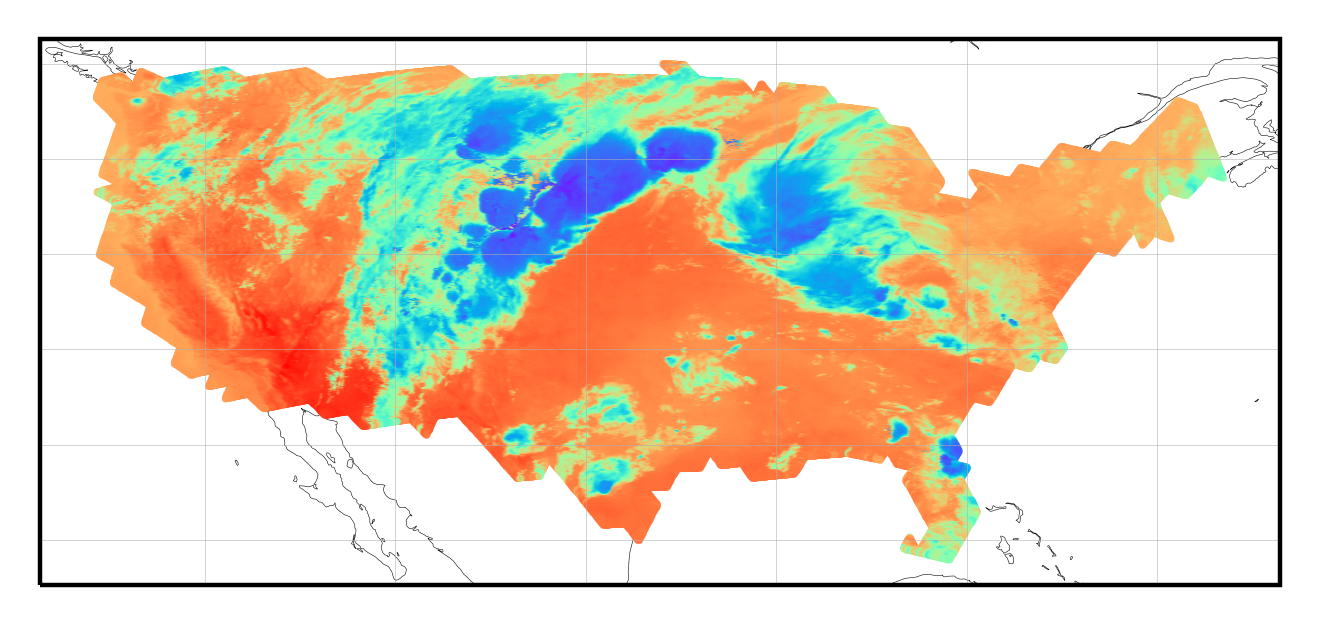

In [23]:
fig, ax = plt.subplots(figsize=(4,4), dpi=400
                       ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)
# ax.grid(True)
if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.05
    marker_alpha=0.5
    
marker='s'

# jdf1.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# jdf1.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(jdf1['lons'],jdf1['lats']
            ,s=marker_size
            ,c=jdf1['BT_12_0um']
            ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
            ,cmap='rainbow'
            ,marker=marker
            ,rasterized=True
            ,transform=ccrs.PlateCarree()
            )
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

# roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
# conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print(datetime.datetime.now() - start0)

In [24]:
print(datetime.datetime.now() - start0)

0:00:56.104738


In [25]:
type(composite)

starepandas.staredataframe.STAREDataFrame

In [26]:
composite_sorted = composite.sort_values('sids')
composite_sorted

,sids,BT_12_0um,lats,lons
59134501,97292061228,284.619995,-29.986486,9.770271
59161141,209793238284,284.910004,-30.040541,9.770271
59161142,259841081932,284.519989,-30.040541,9.797298
59134502,385717242988,284.220001,-29.986486,9.797298
59147822,418474897452,284.320007,-30.013514,9.797298
...,...,...,...,...
32494822,4611685808816186732,293.729980,24.067566,18.445948
32494821,4611685835015846572,293.690002,24.067566,18.418921
32481501,4611685903886623372,293.679993,24.094593,18.418921
32468182,4611685955892864652,293.729980,24.121620,18.445948


In [27]:
composite_sorted['sids'].iloc[0]

97292061228

In [28]:
composite_sorted.to_hdf('composite.h5','stare_sorted',format='fixed',data_columns=['sids','BT_12_0um','lats','lons'])

In [29]:
# !rm composite.h5

In [30]:
# !open composite.h5

In [31]:
import pandas
df = pandas.read_hdf('composite.h5',key='stare_sorted',mode='r',start=32481502,stop=32494822)

In [32]:
df['sids']

73653905    2124908873140814317
73640585    2124908887755067213
73640586    2124908917337691373
73653907    2124908929144547885
73640588    2124908990139612141
                   ...         
73201269    2125535115911769037
73187960    2125535254893082349
73174637    2125535345721697293
73174638    2125535352778294317
73201275    2125535494082185037
Name: sids, Length: 13320, dtype: int64

In [33]:
type(df)

pandas.core.frame.DataFrame

In [34]:
import pandas as pd
import numpy as np
index = pd.date_range("1/1/2000", periods=8)
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
d = pd.DataFrame(np.random.randn(8, 3), index=index, columns=["A", "B", "C"])

In [35]:
d

,A,B,C
2000-01-01,-1.000209,0.478319,-0.186687
2000-01-02,0.504374,-0.657162,-0.662704
2000-01-03,0.374664,2.477541,0.703935
2000-01-04,0.440748,0.141167,1.230508
2000-01-05,0.817182,-0.316195,-0.058155
2000-01-06,-0.658581,-0.470274,-0.054160
2000-01-07,-2.526029,-0.767280,-0.070386
2000-01-08,-0.104178,-1.497306,1.517898


In [36]:
d.to_hdf('d.h5','data',format='fixed',data_columns=['A','B','C'])

In [37]:
# !open d.h5

In [38]:
d1=d.sort_values('A')

In [39]:
d1.to_hdf('d1.h5','data',format='fixed',data_columns=['A','B','C'])

In [40]:
d1

,A,B,C
2000-01-07,-2.526029,-0.767280,-0.070386
2000-01-01,-1.000209,0.478319,-0.186687
2000-01-06,-0.658581,-0.470274,-0.054160
2000-01-08,-0.104178,-1.497306,1.517898
2000-01-03,0.374664,2.477541,0.703935
2000-01-04,0.440748,0.141167,1.230508
2000-01-02,0.504374,-0.657162,-0.662704
2000-01-05,0.817182,-0.316195,-0.058155


In [41]:
# !open d1.h5

In [42]:
def hex16(i):
    return "0x%016x"%i

In [43]:
level = 4
level_increment = pystare.spatial_increment_from_level(level)

nsids_at_level = (8 * (4**level))
sids_at_level = numpy.zeros([nsids_at_level],dtype=numpy.int64)

k = 0
# Plot each increment (overlay on common axes)
for siv_idx, siv in enumerate(range(0, nsids_at_level*level_increment, level_increment)):
    siv = siv + level # Set the level
    sids_at_level[k] = siv
    # print(k,siv,hex16(siv))
    k += 1

In [44]:
stare_row_offsets = numpy.zeros([nsids_at_level],dtype=numpy.int64)

In [45]:
for i in range(10):
    print(composite_sorted['sids'][i+1]-composite_sorted['sids'][i],i)

-25952 0
2176 1
-434848 2
15552 3
2176 4
-8096 5
-60798432 6
32672 7
1600 8
9088 9


In [46]:
def binary_find(s,a):
    n=len(a)
    c=int(n/2)
    d=int(n/2)
    while d>0:
        # print(s,c,d,a.iloc[c])
        d = int(d/2)
        if s > a.iloc[c]:
            c += d
        elif s < a.iloc[c]:
            c -= d
        else:
            d=0
    return c-1

In [47]:
class chunk_lite:
    def __init__(self,start,stop):
        self.start = start
        self.stop  = stop
        return
    
pods_lite = {}
pods_lite_level = level

In [48]:
stare_row_offsets[0] = 0
stare_bounds = {}

for k in range(1,nsids_at_level):
    stare_row_offsets[k] = binary_find(sids_at_level[k],composite_sorted['sids'])
    
for k in range(0,nsids_at_level):
    start = binary_find(sids_at_level[k],composite_sorted['sids'])
    stop  = binary_find(pystare.spatial_terminator(sids_at_level[k]),composite_sorted['sids'])
    if start != stop:
        pods_lite[sids_at_level[k]] = chunk_lite(start,stop)

if False:
    for l in range(nsids_at_level):
        print(l,hex16(sids_at_level[l]),hex16(sids_at_level[l]),hex16(composite_sorted['sids'].iloc[stare_row_offsets[l]]),stare_row_offsets[l])

    for k in pods_lite.keys():
        print(hex16(k),pods_lite[k].start,pods_lite[k].stop)
    

In [49]:
keys = list(pods_lite.keys())
print('len keys: ',len(keys))

len keys:  2048


In [50]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [52]:
# take the intersection, get the level, coerce to it, then uniquify, then loop, load, and concat.
def read_hdf(filename,sids,pods_lite):
    resolution = int(pystare.spatial_resolution(list(pods_lite.keys())[0]))
    
    idx = numpy.unique(
        pystare.spatial_clear_to_resolution(
            pystare.spatial_coerce_resolution(pystare.expand_intervals(sids,resolution),resolution)))
                                              
    # print(idx)
    dfs = []
    for s in idx:
        chunk = pods_lite[s]
        df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)
        dfs.append(df)
        
    return pandas.concat(dfs)

0:00:06.194883
time:  0:00:06.520271


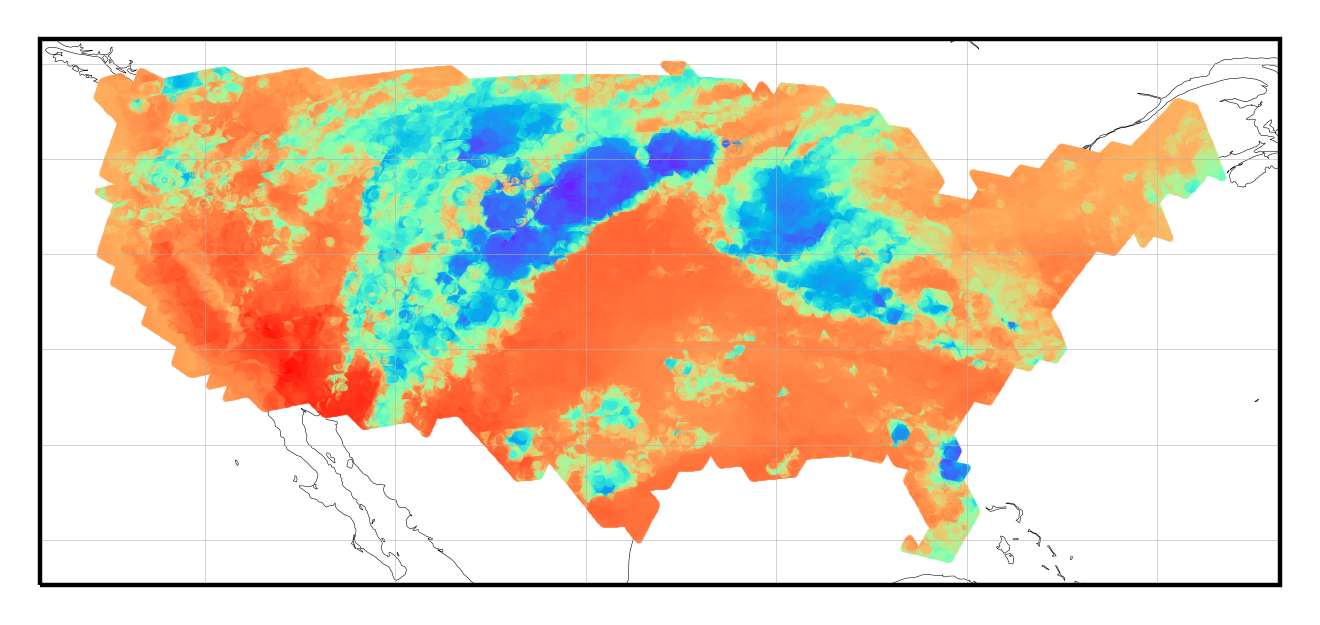

In [71]:
start0 = datetime.datetime.now()

# i = 90
# chunk = pods_lite[keys[i]]
# df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)

# bdf = states[states.NAME=='Hawaii']
# b = states[states.NAME=='Hawaii']['sids'].iloc[0]

b = roi['sids'].iloc[:].to_numpy()

df = starepandas.STAREDataFrame(read_hdf('composite.h5',b,pods_lite)).reset_index()
c = df.stare_intersects(b,n_workers=50)
df = df[c]

print(datetime.datetime.now() - start0)

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(df['lons'],df['lats']
            ,s=marker_size
            ,c=df['BT_12_0um']
            ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
            ,cmap='rainbow'
            ,marker=marker
            ,rasterized=True
            ,transform=ccrs.PlateCarree()
            )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time: ',datetime.datetime.now()-start0)

In [ ]:
print(datetime.datetime.now() - start0)

In [72]:
import xarray

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

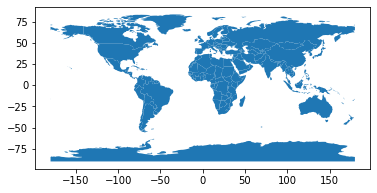

In [80]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

In [96]:
from shapely.geometry import Polygon

<AxesSubplot:>

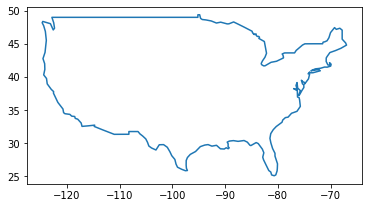

In [100]:
conus_boundary = world[world['name'] == 'United States of America'].clip(
    Polygon([(-125,24.5),(-66,24.5),(-66,49.5),(-125,49.5)])
).boundary
conus_boundary.plot()

In [101]:
data = Dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc', mode='r')

In [116]:
import rasterio
import rasterio.mask
import shapely

In [126]:
shapes = conus_boundary
type(shapes)

geopandas.geoseries.GeoSeries

In [128]:
shapes.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [155]:
src = rasterio.open('ignored/satCORPS/composite_20220420_2019.182.0230.nc',format='netcdf',mode='r')

In [163]:
src.close()

In [162]:
src.tags()

{'NC_GLOBAL#file_version': '2.20',
 'NC_GLOBAL#history': 'Created by K. Khlopenkov (SSAI)  on 04/20/2022 at 19:30:33',
 'NC_GLOBAL#produced_by': 'E-mail: Konstantin.Khlopenkov@nasa.gov; http://www.ssaihq.com',
 'NC_GLOBAL#reference_time': '2019-07-01T02:30:00Z'}

In [156]:
a = src.read()

ValueError: No indexes to read

TypeError: 'DatasetReader' object is not subscriptable

In [112]:
with rasterio.open('ignored/satCORPS/composite_20220420_2019.182.0230.nc') as src:
    out_image, out_transform = rasterio.mask.mask(src, projected_shape, crop=True)
    out_meta = src.meta

ValueError: Input shapes do not overlap raster.

In [87]:
world[world['name'] == 'United States of America'][((world.lat >= 40))]

AttributeError: 'GeoDataFrame' object has no attribute 'lat'

In [82]:
world[world['name'] == 'United States of America']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


## Debugging

In [ ]:
# source_nc = starepandas.io.s3.nc4_dataset_wrapper(granule_name, 'r', format='NETCDF4')

In [ ]:
# data={}

In [ ]:
# data['map_data/BT_12.0m'] = source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)

In [ ]:
# source_nc.groups['map_data']['BT_12.0um'][1000][1000]